In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [3]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices_minute",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(60)
        for i in range(10):
            price[str(i)] = price["adjclose"].shift(i)
        price["y"] = price["adjclose"].shift(-5)
        prices.append(price.dropna())
    except:
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:05<00:00, 96.41it/s]


In [4]:
prices = pd.concat(prices).sort_values("date")

In [29]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(prices["date"].unique()[::2]):
    try:
        # training_dates = [x for x in prices["date"] if x < date][-100:]
        # training_data = prices[prices["date"].isin(training_dates)]
        # sim = prices[prices["date"]==date]
        # model = XGBRegressor(fit_intercept=True)
        # model.fit(training_data[[str(i) for i in range(7)]],training_data["y"])
        # sim["predictions"] = model.predict(sim[[str(i) for i in range(7)]])
        # sim["expected_return"] = (sim["predictions"] - sim["adjclose"]) / sim["adjclose"]
        today = prices[prices["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"]:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

 19%|███████████████████████████▊                                                                                                                       | 169/895 [00:00<00:00, 847.44it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 38%|███████████████████████████████████████████████████████▋                                                                                           | 339/895 [00:00<00:00, 837.79it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 505/895 [00:00<00:00, 794.58it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 664/895 [00:00<00:00, 779.23it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 895/895 [00:01<00:00, 821.67it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

In [30]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]
states["trade"] = states["ticker"] != states["ticker"].shift(-1)

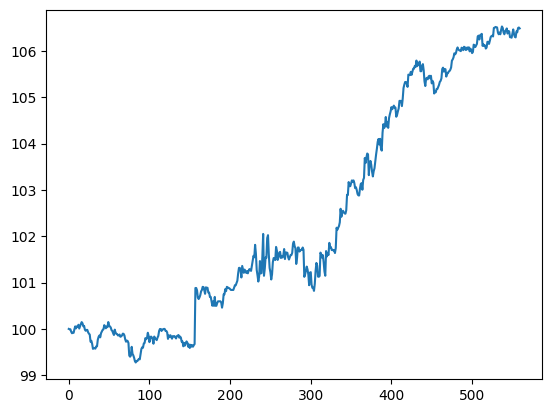

In [31]:
plt.plot(states["pv"])

In [32]:
states[states["trade"]==True]

,ticker,adjclose,quantity,buy_price,date,pv,trade
1,NVDA,122.660,0.815195,122.6700,2024-07-02 09:01:00+00:00,99.991848,True
9,TSLA,208.200,0.480361,208.1600,2024-07-02 09:09:00+00:00,100.011062,True
10,NVDA,122.840,0.814509,122.8400,2024-07-02 09:10:00+00:00,100.054295,True
11,TSLA,208.210,0.480506,208.2100,2024-07-02 09:11:00+00:00,100.046150,True
19,NVDA,122.770,0.815060,122.8000,2024-07-02 09:19:00+00:00,100.064944,True
...,...,...,...,...,...,...,...
526,ENPH,95.335,1.115174,95.3498,2024-07-02 19:16:00+00:00,106.315097,True
551,PCAR,101.100,1.053091,101.1300,2024-07-02 19:41:00+00:00,106.467508,True
556,MTD,1356.430,0.078445,1355.9450,2024-07-02 19:53:00+00:00,106.405511,True
557,PCAR,100.860,1.055900,100.8600,2024-07-02 19:54:00+00:00,106.498076,True
